In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import glob, os
import numpy as np
from comet_ml import Experiment, Optimizer


In [2]:
os.environ['TF_KERAS'] = '1'
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, Input, concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Read data

In [3]:
datadir_T1 = '/home/ana/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/data/'
labels_file_T1 = '/home/ana/eRisk/data/eRisk2020_T1_train/eRISK2020_T1_training_data/eRISK2020_training_data/golden_truth.txt'

In [4]:
labels_T1 = pd.read_csv(labels_file_T1, delimiter=' ', names=['subject', 'label'])

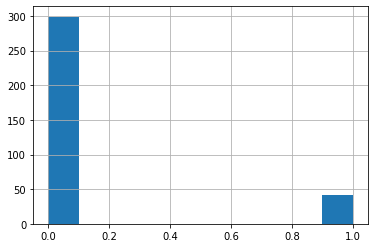

In [5]:
labels_T1.label.hist()

In [6]:
labels_T1 = labels_T1.set_index('subject')
labels_T1

,label
subject,
subject671,1
subject9917,1
subject6238,1
subject8581,1
subject7238,1
...,...
subject2182,0
subject9829,0
subject3270,0


## Read text

In [7]:
writings = []
for subject_file in os.listdir(datadir_T1):
    print(subject_file)
    with open(os.path.join(datadir_T1, subject_file)) as sf:
        contents = sf.read()
        root = ET.fromstring(contents)
        try:
            subject = root.findall('ID')[0].text
        except Exception:
            print('Cannot extract ID', contents[:500], '\n-------\n')        
        for w in root.iter('WRITING'):
            subject_writings = {'subject': subject}
            for title in w.findall('TITLE'):
                subject_writings['title'] = title.text
            for text in w.findall('TEXT'):
                subject_writings['text'] = text.text
            for date in w.findall('DATE'):
                subject_writings['date'] = date.text
            writings.append(subject_writings)
            # TODO: Date



subject8292.xml
subject6644.xml
subject7982.xml
subject9260.xml
subject9918.xml
subject4284.xml
subject9829.xml
subject7661.xml
subject8361.xml
subject4831.xml
subject2181.xml
subject9077.xml
subject2922.xml
subject2238.xml
subject4513.xml
subject269.xml
subject2678.xml
subject9197.xml
subject4143.xml
subject2605.xml
subject4226.xml
subject7627.xml
subject5150.xml
subject4510.xml
subject2182.xml
subject280.xml
subject1105.xml
subject187.xml
subject8001.xml
subject9285.xml
subject2621.xml
subject4414.xml
subject2685.xml
subject9961.xml
subject8065.xml
subject8225.xml
subject6866.xml
subject9949.xml
subject1507.xml
subject8329.xml
subject9411.xml
subject7857.xml
subject1545.xml
subject9811.xml
subject5000.xml
subject4843.xml
subject569.xml
subject51.xml
subject9156.xml
subject6453.xml
subject1210.xml
subject5528.xml
subject1485.xml
subject5935.xml
subject4527.xml
subject3301.xml
subject4074.xml
subject6093.xml
subject2088.xml
subject8990.xml
subject6459.xml
subject7830.xml
subject8395.xm

In [8]:
writings_df = pd.DataFrame(writings)

In [9]:
writings_df['label'] = writings_df['subject'].apply(
    lambda s: labels_T1.loc[s, 'label'])

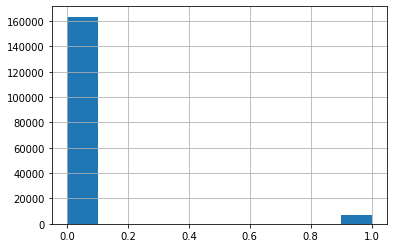

In [10]:
writings_df.label.hist()

In [11]:
tokenizer = RegexpTokenizer(r'\w+')

def tokenize(t):
    return tokenizer.tokenize(t.lower())

In [12]:
writings_df['tokenized_title'] = writings_df['title'].apply(lambda t: tokenize(t) if type(t)==str else None)
writings_df['title_len'] = writings_df['tokenized_title'].apply(lambda t: len(t) if type(t)==list else None)
writings_df['tokenized_text'] = writings_df['text'].apply(lambda t: tokenize(t) if type(t)==str else None)
writings_df['text_len'] = writings_df['tokenized_text'].apply(lambda t: len(t) if type(t)==list else None)

In [13]:
writings_df.text_len.describe()

count    127941.000000
mean         32.268929
std          82.590713
min           0.000000
25%           6.000000
50%          13.000000
75%          31.000000
max        7201.000000
Name: text_len, dtype: float64

In [14]:
writings_df.title_len.describe()

count    49762.000000
mean        10.699771
std          9.282454
min          0.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        149.000000
Name: title_len, dtype: float64

In [15]:
writings_df.groupby('subject').mean()

,label,title_len,text_len
subject,,,
subject0,0,20.285714,31.711712
subject1027,0,7.769231,1.190476
subject1055,0,16.666667,79.983193
subject1064,1,13.000000,68.410256
subject1089,0,9.823529,13.254902
...,...,...,...
subject9917,1,8.983607,95.806897
subject9918,0,5.000000,11.865269
subject992,0,5.872928,19.876190


In [16]:
writings_df.groupby('subject').max().groupby('label').count()

,date,title_len,text_len
label,,,
0,299,296,299
1,41,40,41


In [17]:
print("Average number of posts per user", writings_df.groupby('subject').count().title.mean())
print("Average number of comments per user", writings_df.groupby('subject').count().text.mean())


Average number of posts per user 146.35882352941175
Average number of comments per user 376.2970588235294


# Recurrent NN

## Extract features and encode data

In [87]:
hyperparams_features = {
    "max_features": 20000,
    # cut texts after this number of words
    # (among top max_features most common words)
    "maxlen": 100,
    "embedding_dim": 100
}


### Emotions

In [29]:
def load_NRC(nrc_path):
    word_emotions = {}
    emotion_words = {}
    with open(nrc_path) as in_f:
        for line in in_f:
            line = line.strip()
            if not line:
                continue
            word, emotion, label = line.split()
            if word not in word_emotions:
                word_emotions[word] = set()
            if emotion not in emotion_words:
                emotion_words[emotion] = set()
            label = int(label)
            if label:
                word_emotions[word].add(emotion)
                emotion_words[emotion].add(word)
    return emotion_words

nrc_lexicon_path = '/home/ana/resources/NRC-Sentiment-Emotion-Lexicons/NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt'
nrc_lexicon = load_NRC(nrc_lexicon_path)
emotions = list(nrc_lexicon.keys())


In [30]:
def encode_emotions(tokens, emotion_lexicon, emotions, relative=True):
    text_len = len(tokens)
    encoded_emotions = [0 for e in emotions]
    for i, emotion in enumerate(emotions):
        try:
            emotion_words = [t for t in tokens if t in emotion_lexicon[emotion]]
            if relative:
                encoded_emotions[i] = len(emotion_words) / len(tokens)
            else:
                encoded_emotions[i] = len(emotion_words)
        except ValueError:
            print("Emotion not found.")
    return encoded_emotions

#### Sentiment

### Style features

#### Char n-grams

In [31]:
def extract_ngrams(tokens):
    pass

#### Personal pronouns

In [32]:
first_person_pronouns = {"i", "me", "my", "mine"}
def encode_pronouns(tokens, pronouns={"i", "me", "my", "mine"}, relative=True):
    if not tokens:
        return np.nan
    text_len = len(tokens)
    nr_pronouns = len([t for t in tokens if t in pronouns])
    if relative:
        return nr_pronouns/text_len
    else:
        return nr_pronouns

#### Stopwords

In [33]:
stopword_list = stopwords.words("english")
def encode_stopwords(tokens, stopwords=stopword_list):
    encoded_stopwords = [0 for s in stopword_list]
    if not tokens:
        return encoded_stopwords
    for i, stopword in enumerate(stopwords):
        if stopword in tokens:
            encoded_stopwords[i] += 1
    return encoded_stopwords

### Topics

### Encode data

In [39]:
from collections import Counter
def load_erisk_data(writings_df, voc_size, emotion_lexicon, seq_len, emotions =  
                    ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                     'negative', 'positive', 'sadness', 'surprise', 'trust'],
                    pronouns = ["i", "me", "my", "mine"],
                    train_prop=0.7, min_post_len=3, min_word_len=1):
    print("Loading data...")
    vocabulary = {}
    word_freqs = Counter()
    for words in writings_df.tokenized_text:
        word_freqs.update(words)
    for words in writings_df.tokenized_title:
        word_freqs.update(words)
    i = 1
    for w, f in word_freqs.most_common(voc_size-2): # keeping voc_size-1 for unk
        if len(w) < min_word_len:
            continue
        vocabulary[w] = i
        i += 1
    tokens_data_train = []
    categ_data_train = []
    sparse_data_train = []
    tokens_data_test = []
    categ_data_test = []
    sparse_data_test = []
    labels_train = []
    labels_test = []
    users_train = []
    users_test = []
    all_subjects = sorted(list(set(writings_df.subject)))
    training_subjects_size = int(len(all_subjects) * train_prop)
    training_subjects = all_subjects[:training_subjects_size]
    print(training_subjects_size, "training users, ", len(all_subjects)-training_subjects_size, " test users.")
    training_rows = writings_df[writings_df['subject'].isin(training_subjects)].sample(frac=1) # shuffling
    test_rows = writings_df[~writings_df['subject'].isin(training_subjects)].sample(frac=1)
    positive_training_users = training_rows.groupby('subject').max().groupby('label').count().date[1]
    positive_test_users = test_rows.groupby('subject').max().groupby('label').count().date[1]
    print("Positive training users: ", positive_training_users, ", positive test users: ", positive_test_users)
    def encode_text(tokens):
        # Using voc_size-1 value for OOV token
        encoded_tokens = [vocabulary.get(w, voc_size-1) for w in tokens]
        encoded_emotions = encode_emotions(tokens, emotion_lexicon, emotions)
        encoded_pronouns = encode_pronouns(tokens, pronouns)
        encoded_stopwords = encode_stopwords(tokens)
        return (encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords)
    for row in training_rows.itertuples():
        words = []
        if row.tokenized_title:
            words.extend(row.tokenized_title)
        if row.tokenized_text:
            words.extend(row.tokenized_text)
        if not words or len(words)<min_post_len:
            continue
        label = row.label
        encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = encode_text(words)
        tokens_data_train.append(encoded_tokens)
        categ_data_train.append(encoded_emotions + [encoded_pronouns])
        sparse_data_train.append(encoded_stopwords)
        labels_train.append(label)
        users_train.append(row.subject)
    for row in test_rows[~test_rows['tokenized_text'].isna()].itertuples():
        words = []
        if row.tokenized_title:
            words.extend(row.tokenized_title)
        if row.tokenized_text:
            words.extend(row.tokenized_text)   
        if not words or len(words)<min_post_len:
            continue
        label = row.label
        encoded_tokens, encoded_emotions, encoded_pronouns, encoded_stopwords = encode_text(words)
        tokens_data_test.append(encoded_tokens)
        categ_data_test.append(encoded_emotions + [encoded_pronouns])
        sparse_data_test.append(encoded_stopwords)
        labels_test.append(label)
        users_test.append(row.subject)
        
    # using zeros for padding
    tokens_data_train_padded = sequence.pad_sequences(tokens_data_train, maxlen=seq_len)
    tokens_data_test_padded = sequence.pad_sequences(tokens_data_test, maxlen=seq_len)
        
    return ([np.array(tokens_data_train_padded), np.array(categ_data_train), np.array(sparse_data_train),
            users_train], 
            np.array(labels_train)), \
            ([np.array(tokens_data_test_padded), np.array(categ_data_test), np.array(sparse_data_test),
             users_test], 
             np.array(labels_test)), vocabulary

In [92]:
(x_train, y_train), (x_test, y_test), voc = load_erisk_data(writings_df, 
                                                            seq_len=hyperparams_features['maxlen'],
                                                            voc_size=hyperparams_features['max_features'],
                                                           emotion_lexicon=nrc_lexicon,
                                                           emotions=emotions)

Loading data...
237 training users,  103  test users.
Positive training users:  24 , positive test users:  17


In [93]:
x_train_seq, x_train_categ, x_train_sparse, x_training_users = x_train
x_test_seq, x_test_categ, x_test_sparse, x_test_users = x_test
print(len(x_train_seq), 'train sequences')
print(len(x_test_seq), 'test sequences')

111375 train sequences
31863 test sequences


In [94]:
print(pd.Series(y_train).sum(), "positive training examples")
print(pd.Series(y_test).sum(), "positive test examples")

4430 positive training examples
2092 positive test examples


In [95]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights

array([ 0.52071158, 12.57054176])

In [96]:
def load_embeddings(path, embedding_dim, voc):
    # random matrix with mean value = 0
    embedding_matrix = np.random.random((len(voc)+2, embedding_dim)) - 0.5 # voc + unk + pad value(0)
#     embedding_matrix = np.zeros((len(voc)+1, embedding_dim))

    f = open(path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_i = voc.get(word)
        if word_i is not None:
            embedding_matrix[word_i] = coefs
    f.close()

    print('Total %s word vectors.' % len(embedding_matrix))

 
    return embedding_matrix

# pretrained_embeddings_path = '/home/ana/resources/glove.6B/glove.6B.%dd.txt' % hyperparams_features['embedding_dim']
pretrained_embeddings_path = '/home/ana/resources/glove.twitter.27B/glove.twitter.27B.%dd.txt' % hyperparams_features['embedding_dim']
embedding_matrix = load_embeddings(pretrained_embeddings_path, hyperparams_features['embedding_dim'], voc)


Total 20000 word vectors.


In [97]:
x_train_sparse[90]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

## Define model

In [134]:
hyperparams = {
    'lstm_units': 32,
    'dense_bow_units': 5,
    'dropout': 0.14,
    'l2_dense': 0.00011,
    'optimizer': 'adam', #None,
    'decay': 0.0001,
    'lr': 0.00001,
    "batch_size": 128,
    "trainable_embeddings": True,
    "reduce_lr_factor": 0.2,
    "reduce_lr_patience": 2,
    "freeze_patience": 5,

}
if not hyperparams['optimizer']:
    hyperparams['optimizer'] = optimizers.Adam(lr=hyperparams['lr'], beta_1=0.9, beta_2=0.999, epsilon=1e-08,
                                   decay=hyperparams['decay'])

In [99]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [107]:
def build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopwords_list,
               ignore_layer=[]):

    tokens_features = Input(shape=(hyperparams_features['maxlen'],), name='word_seq')
    embedding_layer = Embedding(hyperparams_features['max_features'], 
                                hyperparams_features['embedding_dim'], 
                                input_length=hyperparams_features['maxlen'],
                                mask_zero=True,
                                weights=[embedding_matrix], 
                                trainable=hyperparams['trainable_embeddings'],
                               name='embeddings_layer')(
        tokens_features)
#     lstm_layers = Bidirectional(LSTM(hyperparams['lstm_units']))(embedding_layer)
    lstm_layers = LSTM(hyperparams['lstm_units'], dropout=hyperparams['dropout'],
                      recurrent_dropout=hyperparams['dropout'],
                      name='LSTM_layer')(embedding_layer)
    
    numerical_features = Input(shape=(len(emotions) + 1,), name='numeric_input') # emotions and pronouns
    dense_layer = Dense(units=1,
                        kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                        name='numerical_dense_layer',
                       )(numerical_features)
    sparse_features = Input(shape=(len(stopwords_list),), name='sparse_input') # stopwords
    dense_layer_sparse = Dense(units=hyperparams['dense_bow_units'],
                              name='sparse_feat_dense_layer',
                                kernel_regularizer=regularizers.l2(hyperparams['l2_dense']),
                              )(sparse_features)
#     # TODO: this is getting out of hand. Refactor this ablation part.
    if 'lstm_layers' in ignore_layer:
        output_layer = Dense(1, activation='sigmoid')(numerical_features)
    elif 'numerical_dense_layer' in ignore_layer and 'sparse_feat_dense_layer' in ignore_layer:
        output_layer = Dense(1, activation='sigmoid')(lstm_layers)
    elif 'numerical_dense_layer' in ignore_layer:
        merged_layers = concatenate([lstm_layers, dense_layer_sparse])
        output_layer = Dense(1, activation='sigmoid')(merged_layers)

    elif 'sparse_feat_dense_layer' in ignore_layer:
        merged_layers = concatenate([lstm_layers, dense_layer])
        output_layer = Dense(1, activation='sigmoid')(merged_layers)

    else:
        merged_layers = concatenate([lstm_layers, dense_layer, dense_layer_sparse])
        output_layer = Dense(1, activation='sigmoid')(merged_layers)

    # Compile model
    model = Model(inputs=[tokens_features, numerical_features, sparse_features], outputs=output_layer)
    model.compile(hyperparams['optimizer'], 'binary_crossentropy',
                  metrics=['binary_accuracy', f1_m, precision_m, recall_m])
    
    return model


In [108]:
model = build_model(hyperparams, hyperparams_features, embedding_matrix, emotions, stopword_list,
                   ignore_layer=[])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word_seq (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
embeddings_layer (Embedding)    (None, 100, 100)     2000000     word_seq[0][0]                   
__________________________________________________________________________________________________
numeric_input (InputLayer)      (None, 11)           0                                            
__________________________________________________________________________________________________
sparse_input (InputLayer)       (None, 179)          0                                            
__________________________________________________________________________________________________
LSTM_layer

In [ ]:
plot_model(model, 'models/lstm_plus7.png')

In [109]:
experiment = Experiment(api_key="eoBdVyznAhfg3bK9pZ58ZSXfv",
                        project_name="mental", workspace="ananana")

experiment.log_parameters(hyperparams_features)

experiment.log_parameter('emotion_lexicon', nrc_lexicon_path)
experiment.log_parameter('emotions', emotions)
experiment.log_parameter('embeddings_path', pretrained_embeddings_path)

experiment.log_parameters(hyperparams)

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/ananana/mental/24160d5b42f4454584ff1ffc85207d5e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01    : (82.9, 82.9)
COMET INFO:     sys.cpu.percent.02    : (49.9, 49.9)
COMET INFO:     sys.cpu.percent.03    : (36.3, 36.3)
COMET INFO:     sys.cpu.percent.04    : (34.9, 34.9)
COMET INFO:     sys.cpu.percent.avg   : (51.00000000000001, 51.00000000000001)
COMET INFO:     sys.gpu.0.total_memory: (1073414144.0, 1073414144.0)
COMET INFO:     sys.load.avg          : (1.27, 1.27)
COMET INFO:     sys.ram.total         : (8277307392.0, 8277307392.0)
COMET INFO:     sys.ram.used          : (6003113984.0, 6003113984.0)
COMET INFO:   Uploads:
COMET INFO:     git-patch: 1
COMET INFO: ----------------------------
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ananana/mental/76e9847ca5eb4e5982dead933a5c8f85



In [103]:
voc

{'the': 1,
 'i': 2,
 'to': 3,
 'a': 4,
 'and': 5,
 'of': 6,
 'it': 7,
 'in': 8,
 'you': 9,
 'that': 10,
 'is': 11,
 's': 12,
 'for': 13,
 'this': 14,
 't': 15,
 'on': 16,
 'with': 17,
 'but': 18,
 'my': 19,
 '8217': 20,
 'be': 21,
 'was': 22,
 'have': 23,
 'are': 24,
 'not': 25,
 'they': 26,
 'as': 27,
 'if': 28,
 'so': 29,
 'just': 30,
 'what': 31,
 'can': 32,
 'like': 33,
 'he': 34,
 'or': 35,
 'at': 36,
 'we': 37,
 'me': 38,
 'from': 39,
 'your': 40,
 'm': 41,
 'do': 42,
 'com': 43,
 'all': 44,
 'about': 45,
 'an': 46,
 'one': 47,
 'there': 48,
 'would': 49,
 'out': 50,
 'up': 51,
 'when': 52,
 'more': 53,
 'get': 54,
 'don': 55,
 'people': 56,
 'by': 57,
 'will': 58,
 'no': 59,
 'how': 60,
 'https': 61,
 'gt': 62,
 'has': 63,
 'them': 64,
 'his': 65,
 'time': 66,
 'some': 67,
 're': 68,
 'know': 69,
 'think': 70,
 'who': 71,
 'their': 72,
 'because': 73,
 'had': 74,
 'she': 75,
 'here': 76,
 'good': 77,
 'really': 78,
 'www': 79,
 'r': 80,
 'now': 81,
 've': 82,
 'been': 83,
 'only

## Train

In [110]:
class WeightsHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.log_weights(0)

    def on_epoch_end(self, epoch, logs={}):
        self.log_weights(epoch)
        
    def log_weights(self, step):
        experiment.log_histogram_3d(self.model.get_layer('LSTM_layer').get_weights()[0], name='lstm_weights',
                                   step=step)  
        experiment.log_histogram_3d(model.get_layer('embeddings_layer').get_weights()[0], 
                            name='embedding_weights',
                           step=step)
        experiment.log_histogram_3d(model.get_layer('numerical_dense_layer').get_weights()[0], 
                                    name='numerical_dense_weights',
                                   step=step)
        experiment.log_histogram_3d(model.get_layer('sparse_feat_dense_layer').get_weights()[0], 
                            name='sparse_dense_weights',
                           step=step)
        
        
class FreezeLayer(callbacks.Callback):
    def __init__(self, logs={}, patience=5, layer='embeddings_layer', verbose=1, set_to=False):
        super(FreezeLayer, self).__init__()
        self.freeze_epoch = patience
        self.freeze_layer = layer
        self.verbose = verbose
        self.set_to = set_to

    def on_epoch_begin(self, epoch, logs={}):
        if epoch == self.freeze_epoch:
            layer = model.get_layer(self.freeze_layer)
            old_value = layer.trainable
            layer.trainable = self.set_to
            if self.verbose:
                print("Setting %s layer from %s to trainable=%s..." % (layer.name, old_value,
                                                               model.get_layer(self.freeze_layer).trainable))


In [124]:
def train_model(model, 
                x_train, y_train, x_test, y_test, 
                batch_size, epochs, class_weight, start_epoch=0, workers=4,
                callback_list = [],
                model_path='/tmp/model'):
    print('Train...')
    experiment.log_parameter('class_weight', class_weight.values())
    experiment.log_parameter('callbacks', callbacks)

    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs, initial_epoch=start_epoch, 
              class_weight=class_weight,
              validation_data=[x_test, y_test],
#               validation_split=0.3,
                       workers=workers,
            callbacks = [
                callbacks.ModelCheckpoint(filepath='%s_best' % model_path, verbose=1, save_best_only=True),
                callbacks.EarlyStopping(patience=5), *callback_list
            ])
    model.save(model_path)
    experiment.log_parameter('model_path', model_path)
    return history

In [ ]:
%%time

freeze_layer = FreezeLayer(hyperparams['freeze_patience'], set_to=not hyperparams['trainable_embeddings'])
weights_history = WeightsHistory()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=hyperparams['reduce_lr_factor'],
                          patience=hyperparams['reduce_lr_patience'], min_lr=0.000001, verbose=1)

history = train_model(model, x_train, y_train, x_test, y_test,
           epochs=15, batch_size=hyperparams['batch_size'],
                      class_weight={0:0.5, 1:12}, 
                      callback_list = [freeze_layer, weights_history, reduce_lr],
                      model_path='models/lstm_plus7', workers=2)

Train...
Train on 111375 samples, validate on 31863 samples


COMET WARNING: Set model graph ignored; already set and not overwrite


Epoch 1/15
 30592/111375 [=======>......................] - ETA: 3:40 - loss: 0.6312 - binary_accuracy: 0.7075 - f1_m: 0.1291 - precision_m: 0.0753 - recall_m: 0.5474

In [165]:
model.get_weights()

[array([[ 1.5279915e-02,  4.7590178e-01, -4.8616432e-02, ...,
          4.0647617e-01,  4.0538330e-02,  2.4765652e-01],
        [ 9.5151998e-02,  3.7024000e-01,  5.4290998e-01, ...,
         -5.1082999e-01,  4.6877000e-01,  3.4882000e-01],
        [-3.9621000e-04,  4.5670000e-01,  3.3890000e-01, ...,
         -4.2910001e-01,  1.0746000e+00, -3.6550000e-01],
        ...,
        [-7.0870000e-01, -6.0604000e-01, -4.4224000e-01, ...,
         -8.3099999e-02,  5.5158000e-02,  2.5769001e-01],
        [ 3.9036000e-01, -5.7444000e-01, -6.5509999e-01, ...,
         -5.7653999e-01,  9.5931001e-02,  1.0454000e+00],
        [-4.4363201e-01,  1.0039248e-01,  6.3836761e-02, ...,
          2.6907095e-01,  7.8583762e-02, -3.8874221e-01]], dtype=float32),
 array([[ 0.05118892,  0.01830989, -0.0848855 , ...,  0.14976056,
          0.04705308, -0.06339781],
        [ 0.00329915, -0.05218123,  0.13718773, ..., -0.03093715,
         -0.07668457, -0.17208682],
        [ 0.01844802,  0.02189548, -0.00731012

In [107]:
plot_model(model, to_file='models/lstm_plus4.png')

In [ ]:
dependencies = {
    'f1_m': f1_m,
    'precision_m': precision_m,
    'recall_m': recall_m
}
# model = load_model('models/lstm_plus1', custom_objects=dependencies)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
pd.Series(predictions.flatten()).hist()

In [ ]:
sum(predictions>0.5)

In [ ]:
sum(predictions<0.5)

## Extra analysis


In [18]:
def merge_tokens(row):
    tokens = []
    if row.tokenized_text:
        tokens += row.tokenized_text
    if row.tokenized_title:
        tokens += row.tokenized_title
    return tokens
writings_df['all_tokens'] = writings_df.apply (lambda row: merge_tokens(row), axis=1)

In [123]:
# TODO: include the title
def extract_emotions(tokens, emotion, relative=True):
    if not tokens:
        return None
    emotion_words = [t for t in tokens 
                     if t in nrc_lexicon[emotion]]
    if relative:
        return len(emotion_words) / len(tokens)
    else:
        return len(emotion_words)
    
    return encoded_emotions

from functools import partial
for emotion in emotions:
    writings_df[emotion] = writings_df['all_tokens'].apply(partial(extract_emotions, emotion=emotion, 
                                                                   relative=True))


In [124]:
writings_df['pronouns'] = writings_df['all_tokens'].apply(partial(encode_pronouns, relative=True))

In [100]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].corr()

,label,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.104269,0.011986,0.020197,0.031982,0.031271,0.019335,0.040782,0.023853,0.023621,0.032969,0.020421,0.023590
pronouns,0.104269,1.000000,0.636745,0.449384,0.567496,0.452098,0.464899,0.548570,0.513029,0.571303,0.524614,0.461328,0.538335
text_len,0.011986,0.636745,1.000000,0.708853,0.791715,0.642980,0.738146,0.728836,0.823974,0.867609,0.723653,0.650420,0.834939
anger,0.020197,0.449384,0.708853,1.000000,0.643459,0.762591,0.858442,0.564162,0.835345,0.681573,0.774846,0.583704,0.671042
anticipation,0.031982,0.567496,0.791715,0.643459,1.000000,0.573916,0.668326,0.834784,0.684882,0.849864,0.668269,0.727331,0.818885
disgust,0.031271,0.452098,0.642980,0.762591,0.573916,1.000000,0.729799,0.526733,0.765865,0.603013,0.737717,0.540439,0.589641
fear,0.019335,0.464899,0.738146,0.858442,0.668326,0.729799,1.000000,0.570632,0.862778,0.706676,0.824782,0.569688,0.687232
joy,0.040782,0.548570,0.728836,0.564162,0.834784,0.526733,0.570632,1.000000,0.604964,0.850961,0.603296,0.722710,0.811529
negative,0.023853,0.513029,0.823974,0.835345,0.684882,0.765865,0.862778,0.604964,1.000000,0.735431,0.840379,0.597634,0.706808
positive,0.023621,0.571303,0.867609,0.681573,0.849864,0.603013,0.706676,0.850961,0.735431,1.000000,0.702751,0.678778,0.916526


In [99]:
writings_df[['text', 'label', 'pronouns', 'text_len'] + emotions].groupby('label').mean()

,pronouns,text_len,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,
0,0.868213,32.031615,0.386069,0.58984,0.263683,0.478014,0.479908,0.818800,1.280788,0.385315,0.284790,0.830560
1,2.484271,36.398389,0.529232,0.86985,0.416203,0.654371,0.769766,1.152422,1.717428,0.627088,0.375418,1.128341


In [108]:
from nltk.sentiment import SentimentAnalyzer, SentimentIntensityAnalyzer

In [112]:
sid = SentimentIntensityAnalyzer()


In [115]:
sid.polarity_scores("We are here today happiness is all around")

{'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compound': 0.5574}

In [117]:
writings_df['neg_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['neg']
                                                 if type(t)==str else 0)

In [118]:
writings_df

,subject,title,date,text,label,tokenized_title,title_len,tokenized_text,text_len,emotions,...,fear,joy,negative,positive,sadness,surprise,trust,pronouns,all_tokens,neg_vader
0,subject8292,If anyone could help with which sub to put thi...,2016-08-02 09:22:12,NaN,0,"[if, anyone, could, help, with, which, sub, to...",11.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[if, anyone, could, help, with, which, sub, to...",0.000
1,subject8292,I'm literally never gonna stop waiting...,2016-08-05 09:35:55,NaN,0,"[i, m, literally, never, gonna, stop, waiting]",7.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[i, m, literally, never, gonna, stop, waiting]",0.000
2,subject8292,This is a really interesting study! Makes sens...,2016-08-05 21:36:24,NaN,0,"[this, is, a, really, interesting, study, make...",9.0,None,NaN,NaN,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,"[this, is, a, really, interesting, study, make...",0.000
3,subject8292,The only thing Frank is building ...,2016-08-07 23:35:23,"... Is hype. Think about it, every time he wor...",0,"[the, only, thing, frank, is, building]",6.0,"[is, hype, think, about, it, every, time, he, ...",26.0,0.000000,...,0.0,0.0,3.0,3.0,0.0,0.0,1.0,0.0,"[is, hype, think, about, it, every, time, he, ...",0.000
4,subject8292,Mostly always me during this whole charade,2016-08-09 08:39:41,NaN,0,"[mostly, always, me, during, this, whole, char...",7.0,None,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,"[mostly, always, me, during, this, whole, char...",0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170693,subject217,NaN,2018-08-19 11:29:21,"this is my personal experience ,it may not ref...",0,None,NaN,"[this, is, my, personal, experience, it, may, ...",153.0,0.026144,...,1.0,1.0,1.0,7.0,0.0,1.0,4.0,4.0,"[this, is, my, personal, experience, it, may, ...",0.089
170694,subject217,NaN,2018-08-19 16:17:34,stop looking at 20 million saudis as one entit...,0,None,NaN,"[stop, looking, at, 20, million, saudis, as, o...",15.0,0.000000,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[stop, looking, at, 20, million, saudis, as, o...",0.145
170695,subject217,NaN,2018-08-19 20:00:31,i am aware of stats now and then. i was just s...,0,None,NaN,"[i, am, aware, of, stats, now, and, then, i, w...",198.0,0.030303,...,2.0,3.0,4.0,11.0,3.0,0.0,6.0,16.0,"[i, am, aware, of, stats, now, and, then, i, w...",0.070
170696,subject217,WHAT DID YOU SAY TO ME?,2018-08-20 10:54:11,NaN,0,"[what, did, you, say, to, me]",6.0,None,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"[what, did, you, say, to, me]",0.000


In [119]:
writings_df['pos_vader'] = writings_df.text.apply(lambda t: sid.polarity_scores(t)['pos']
                                                 if type(t)==str else 0)

In [120]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].groupby('label').mean()

,pronouns,text_len,neg_vader,pos_vader,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,,,,,,,,,,,,,,
0,0.868213,32.031615,0.054259,0.109981,0.386069,0.58984,0.263683,0.478014,0.479908,0.818800,1.280788,0.385315,0.284790,0.830560
1,2.484271,36.398389,0.079191,0.148154,0.529232,0.86985,0.416203,0.654371,0.769766,1.152422,1.717428,0.627088,0.375418,1.128341


In [125]:
writings_df[['text', 'label', 'pronouns', 'text_len', 'neg_vader', 'pos_vader'] + emotions].corr('spearman')

,label,pronouns,text_len,neg_vader,pos_vader,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
label,1.000000,0.097800,0.033477,0.067170,0.065211,0.022057,0.025666,0.030664,0.019114,0.033977,0.022934,0.019590,0.032641,0.018109,0.024014
pronouns,0.097800,1.000000,0.332071,0.193938,0.221419,0.076345,0.128030,0.094069,0.063176,0.144011,0.076670,0.106055,0.100827,0.106790,0.122914
text_len,0.033477,0.332071,1.000000,0.343154,0.159673,0.360460,0.386351,0.312393,0.381410,0.339398,0.370250,0.330075,0.384031,0.349498,0.389620
neg_vader,0.067170,0.193938,0.343154,1.000000,0.169624,0.384510,0.141868,0.362582,0.339245,0.126042,0.431111,0.099767,0.374256,0.159302,0.143060
pos_vader,0.065211,0.221419,0.159673,0.169624,1.000000,0.079693,0.225925,0.087309,0.071450,0.323148,0.058266,0.270687,0.095040,0.186243,0.231954
anger,0.022057,0.076345,0.360460,0.384510,0.079693,1.000000,0.196795,0.583864,0.587460,0.157202,0.631708,0.128169,0.528980,0.273195,0.169261
anticipation,0.025666,0.128030,0.386351,0.141868,0.225925,0.196795,1.000000,0.164649,0.241958,0.583107,0.178827,0.452457,0.198972,0.460851,0.469028
disgust,0.030664,0.094069,0.312393,0.362582,0.087309,0.583864,0.164649,1.000000,0.440376,0.152731,0.552021,0.116588,0.490181,0.232166,0.153723
fear,0.019114,0.063176,0.381410,0.339245,0.071450,0.587460,0.241958,0.440376,1.000000,0.159907,0.576962,0.141985,0.583703,0.248160,0.184240
joy,0.033977,0.144011,0.339398,0.126042,0.323148,0.157202,0.583107,0.152731,0.159907,1.000000,0.113400,0.645827,0.176440,0.477317,0.582920


### LIWC

In [19]:
from liwc_readDict import readDict

liwc = readDict('/home/ana/resources/FakeOrFact/features/LIWC/LIWC/liwc.dic')

In [20]:
categories = [c for (w,c) in liwc]
set(categories)

{'achieve',
 'adverb',
 'affect',
 'anger',
 'anx',
 'article',
 'assent',
 'auxverb',
 'bio',
 'body',
 'cause',
 'certain',
 'cogmech',
 'conj',
 'death',
 'discrep',
 'excl',
 'family',
 'feel',
 'filler',
 'friend',
 'funct',
 'future',
 'health',
 'hear',
 'home',
 'humans',
 'i',
 'incl',
 'ingest',
 'inhib',
 'insight',
 'ipron',
 'leisure',
 'money',
 'motion',
 'negate',
 'negemo',
 'nonfl',
 'number',
 'past',
 'percept',
 'posemo',
 'ppron',
 'preps',
 'present',
 'pronoun',
 'quant',
 'relativ',
 'relig',
 'sad',
 'see',
 'sexual',
 'shehe',
 'social',
 'space',
 'swear',
 'tentat',
 'they',
 'time',
 'verb',
 'we',
 'work',
 'you'}

In [21]:
liwc

[['a', 'funct'],
 ['a', 'article'],
 ['abandon*', 'affect'],
 ['abandon*', 'negemo'],
 ['abandon*', 'sad'],
 ['abandon*', 'cogmech'],
 ['abandon*', 'inhib'],
 ['abdomen*', 'bio'],
 ['abdomen*', 'body'],
 ['abilit*', 'achieve'],
 ['able*', 'achieve'],
 ['abortion*', 'bio'],
 ['abortion*', 'health'],
 ['abortion*', 'sexual'],
 ['about', 'funct'],
 ['about', 'adverb'],
 ['about', 'preps'],
 ['above', 'funct'],
 ['above', 'preps'],
 ['above', 'space'],
 ['above', 'relativ'],
 ['abrupt*', 'time'],
 ['abrupt*', 'relativ'],
 ['abs', 'bio'],
 ['abs', 'body'],
 ['absent*', 'work'],
 ['absolute', 'cogmech'],
 ['absolute', 'certain'],
 ['absolutely', 'funct'],
 ['absolutely', 'adverb'],
 ['absolutely', 'cogmech'],
 ['absolutely', 'certain'],
 ['absolutely', 'assent'],
 ['abstain*', 'cogmech'],
 ['abstain*', 'inhib'],
 ['abuse*', 'affect'],
 ['abuse*', 'negemo'],
 ['abuse*', 'anger'],
 ['abusi*', 'affect'],
 ['abusi*', 'negemo'],
 ['abusi*', 'anger'],
 ['academ*', 'work'],
 ['accept', 'affect'],
 

In [22]:
liwc_dict = {}
for (w, c) in liwc:
    if c not in liwc_dict:
        liwc_dict[c] = []
    liwc_dict[c].append(w)


In [23]:
liwc_dict['pronoun']

['anybod*',
 'anyone*',
 'anything',
 'everybod*',
 'everyone*',
 'everything*',
 'he',
 "he'd",
 "he's",
 'hed',
 'her',
 'hers',
 'herself',
 'hes',
 'him',
 'himself',
 'his',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'id',
 'im',
 'it',
 "it'd",
 "it'll",
 "it's",
 'itd',
 'itll',
 'its',
 'itself',
 'ive',
 "let's",
 'lets',
 'me',
 'mine',
 'my',
 'myself',
 'nobod*',
 'oneself',
 'other',
 'others',
 'our',
 'ours',
 'ourselves',
 'she',
 "she'd",
 "she'll",
 "she's",
 'shes',
 'somebod*',
 'someone*',
 'something*',
 'somewhere',
 'stuff',
 'that',
 "that'd",
 "that'll",
 "that's",
 'thatd',
 'thatll',
 'thats',
 'thee',
 'their*',
 'them',
 'themselves',
 'these',
 'they',
 "they'd",
 "they'll",
 "they've",
 'theyd',
 'theyll',
 'theyve',
 'thine',
 'thing*',
 'this',
 'those',
 'thou',
 'thoust',
 'thy',
 'us',
 'we',
 "we'd",
 "we'll",
 "we're",
 "we've",
 'weve',
 'what',
 "what's",
 'whatever',
 'whats',
 'which',
 'whichever',
 'who',
 "who'd",
 "who'll",
 'whod',
 'wholl'

In [24]:
def encode_liwc_categories(tokens, category_words, relative=True):
    category_cnt = 0
    if not tokens:
        return None
    text_len = len(tokens)
    for t in tokens:
        for word in category_words:
            if t==word or (word[-1]=='*' and t.startswith(word[:-1])) \
            or (t==word.split("'")[0]):
                category_cnt += 1
                break # one token cannot belong to more than one word in the category
    if relative:
        return category_cnt/text_len
    else:
        return category_cnt

In [25]:
%%time
from functools import partial
# for categ in ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']:#liwc_dict.keys():
for categ in liwc_dict.keys():
    if categ in writings_df.columns:
        continue
    print("Encoding for category %s..." % categ)
    writings_df[categ] = writings_df['all_tokens'].apply(partial(encode_liwc_categories, 
                                                                   category_words=liwc_dict[categ], 
                                                                   relative=True))


Encoding for category funct...
Encoding for category article...
Encoding for category affect...
Encoding for category negemo...
Encoding for category sad...
Encoding for category cogmech...
Encoding for category inhib...
Encoding for category bio...
Encoding for category body...
Encoding for category achieve...
Encoding for category health...
Encoding for category sexual...
Encoding for category adverb...
Encoding for category preps...
Encoding for category space...
Encoding for category relativ...
Encoding for category time...
Encoding for category work...
Encoding for category certain...
Encoding for category assent...
Encoding for category anger...
Encoding for category posemo...
Encoding for category insight...
Encoding for category verb...
Encoding for category past...
Encoding for category money...
Encoding for category percept...
Encoding for category social...
Encoding for category friend...
Encoding for category motion...
Encoding for category cause...
Encoding for category le

In [122]:
writings_df[writings_df['i']>1]
encode_liwc_categories(['i','m','going'], liwc_dict['i'])

0.3333333333333333

In [29]:
import pickle
pickle.dump(writings_df, open("writings_df_liwc3", "wb+"))

In [2]:
import pickle
writings_df = pickle.load(open("writings_df_liwc_part", "rb"))
writings_df.columns

Index(['subject', 'title', 'date', 'text', 'label', 'tokenized_title',
       'title_len', 'tokenized_text', 'text_len', 'all_tokens', 'funct',
       'article', 'affect', 'negemo', 'sad', 'cogmech', 'inhib', 'bio', 'body',
       'achieve', 'health', 'sexual', 'adverb', 'preps', 'space', 'relativ',
       'time', 'work', 'certain', 'assent', 'anger', 'posemo', 'insight',
       'verb', 'past', 'money', 'percept'],
      dtype='object')

In [50]:
writings_df[['label'] + list(liwc_dict.keys())].corr().sort_values(by='label', ascending=False)[:50]

,label,funct,article,affect,negemo,sad,cogmech,inhib,bio,body,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
label,1.000000,0.066626,-0.011048,0.012005,0.007687,0.003770,0.041658,0.000530,0.013280,0.005446,...,0.012789,0.030731,0.057426,-0.007159,0.072440,0.017103,0.072866,-0.005369,0.018728,0.016379
i,0.072866,0.272193,-0.085553,-0.029747,-0.014977,0.007909,0.053720,-0.015168,0.001689,-0.004427,...,-0.003370,0.039280,0.395652,-0.012364,0.672227,-0.035447,1.000000,-0.042941,-0.034232,-0.028312
ppron,0.072440,0.434561,-0.116059,-0.001906,-0.016102,0.009627,0.099705,-0.010223,-0.001588,-0.001485,...,-0.010589,0.056509,0.620799,-0.021183,1.000000,0.290994,0.672227,0.202615,0.529791,0.202899
pronoun,0.070690,0.593894,-0.113121,-0.021588,-0.012200,0.006597,0.140101,-0.009750,-0.016443,-0.018998,...,-0.016266,0.095948,0.722701,-0.027504,0.769984,0.201579,0.529107,0.149585,0.412793,0.149853
funct,0.066626,1.000000,0.296737,-0.137328,-0.049658,-0.005907,0.351275,-0.007653,-0.066292,-0.044489,...,-0.028299,0.275794,0.490716,-0.034641,0.434561,0.134153,0.272193,0.108061,0.215911,0.148942
verb,0.061880,0.555489,-0.054100,0.089376,-0.003435,0.011896,0.207386,0.013583,-0.011748,-0.053059,...,-0.016769,0.080685,0.760086,-0.024497,0.513685,0.110016,0.293276,0.105723,0.360806,0.101307
present,0.060737,0.489522,-0.065232,0.118123,-0.000837,-0.002619,0.165773,0.014491,0.002479,-0.046410,...,-0.010617,0.065952,0.710962,-0.026025,0.513764,0.084266,0.284551,0.108646,0.389053,0.094309
future,0.057426,0.490716,-0.072864,-0.001918,-0.018312,0.002283,0.184515,-0.010025,-0.035488,-0.041999,...,-0.014748,0.105019,1.000000,-0.017047,0.620799,0.142641,0.395652,0.102732,0.392511,0.116274
auxverb,0.056858,0.635402,-0.038364,-0.046281,-0.021598,0.000881,0.167013,-0.008930,-0.052483,-0.049837,...,-0.025299,0.103584,0.809318,-0.023971,0.508941,0.117414,0.298278,0.112858,0.333056,0.115425
conj,0.046422,0.342014,0.001092,-0.057705,-0.015910,0.008813,0.316203,-0.004944,-0.015471,-0.015445,...,0.006521,0.290814,0.099640,-0.008195,0.068227,0.039059,0.022491,0.009470,0.030777,0.071332


In [51]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

,label,negemo,posemo,affect,sad,anx,pronoun
label,1.000000,0.007687,0.008943,0.012005,0.003770,0.009488,0.070690
negemo,0.007687,1.000000,-0.058048,0.456381,0.356025,0.303006,-0.012200
posemo,0.008943,-0.058048,1.000000,0.860121,-0.020983,-0.024652,-0.016989
affect,0.012005,0.456381,0.860121,1.000000,0.162322,0.131990,-0.021588
sad,0.003770,0.356025,-0.020983,0.162322,1.000000,0.004730,0.006597
anx,0.009488,0.303006,-0.024652,0.131990,0.004730,1.000000,-0.005745
pronoun,0.070690,-0.012200,-0.016989,-0.021588,0.006597,-0.005745,1.000000


In [52]:
writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].corr()

,label,negemo,posemo,affect,sad,anx,pronoun
label,1.000000,0.089955,0.052222,0.083142,0.160260,0.256804,0.426963
negemo,0.089955,1.000000,-0.116086,0.219462,0.471302,0.368127,0.140835
posemo,0.052222,-0.116086,1.000000,0.943433,-0.006218,-0.123012,0.155976
affect,0.083142,0.219462,0.943433,1.000000,0.152016,0.003445,0.202396
sad,0.160260,0.471302,-0.006218,0.152016,1.000000,0.124741,0.151703
anx,0.256804,0.368127,-0.123012,0.003445,0.124741,1.000000,0.189642
pronoun,0.426963,0.140835,0.155976,0.202396,0.151703,0.189642,1.000000


In [48]:
writings_df.groupby('subject').mean()[['label'] + list(liwc_dict.keys())].corr().sort_values(by='label', 
                                                                                             ascending=True
                                                                                             
                                                                                            )[:50]

,label,funct,article,affect,negemo,sad,cogmech,inhib,bio,body,...,feel,excl,future,nonfl,ppron,shehe,i,we,you,they
work,-0.197958,-0.078190,0.164134,-0.161045,-0.110000,-0.119536,-0.001790,0.173579,-0.185892,-0.108384,...,-0.159383,-0.140420,-0.213641,-0.152713,-0.255025,-0.089858,-0.225474,0.030485,-0.160479,0.007994
article,-0.124233,0.396806,1.000000,-0.240369,0.008891,-0.012702,0.263779,0.074441,0.052556,0.050284,...,0.020717,0.138179,-0.001219,-0.063174,-0.118329,0.128260,-0.185701,0.204698,-0.171638,0.200865
we,-0.116822,0.151113,0.204698,-0.155738,0.001092,0.092360,0.157903,0.036809,-0.062165,-0.041142,...,-0.093426,0.016650,0.092645,-0.102804,0.071740,0.061737,-0.146144,1.000000,-0.067507,0.235515
leisure,-0.112231,-0.143708,-0.004798,-0.086731,-0.062152,-0.124786,-0.083327,-0.067570,-0.094987,-0.002267,...,-0.036881,-0.117458,-0.208380,-0.010841,-0.219850,-0.015029,-0.224056,0.060854,-0.111190,-0.074291
relig,-0.111693,-0.168276,-0.113201,-0.002934,0.131581,0.019087,-0.168061,-0.009963,0.131917,0.120496,...,-0.117415,-0.182714,-0.124955,0.141870,-0.088337,0.022296,-0.016868,0.006271,-0.155717,-0.087777
nonfl,-0.106273,-0.142126,-0.063174,-0.014140,-0.049783,-0.008109,-0.178262,0.035345,-0.021263,-0.073612,...,-0.116472,-0.077630,-0.085311,1.000000,-0.081097,-0.074875,-0.038144,-0.102804,-0.002113,-0.111409
body,-0.104611,0.020413,0.050284,0.027907,0.286784,0.029595,-0.016621,0.095378,0.726711,1.000000,...,0.197435,-0.053477,0.034320,-0.073612,0.085061,0.265476,0.023886,-0.041142,0.029384,-0.052626
achieve,-0.084893,0.194331,0.211335,0.049867,0.018182,0.105555,0.209111,0.121165,-0.018950,-0.013264,...,0.013355,0.088796,0.022842,-0.116076,-0.067931,-0.028410,-0.081458,0.108604,-0.066106,0.079667
swear,-0.081571,-0.058793,-0.140552,0.268508,0.612112,0.116701,-0.062664,0.104361,0.504148,0.447440,...,-0.037921,-0.074382,0.034313,0.062913,0.037438,0.095309,0.011738,-0.047332,0.047864,-0.066267
inhib,-0.076475,0.062455,0.074441,-0.035806,0.265704,0.210793,0.147004,1.000000,0.142278,0.095378,...,-0.028874,-0.031337,-0.045026,0.035345,-0.084656,0.019355,-0.092080,0.036809,-0.061055,-0.002713


In [107]:
def plot_emotion_distr_per_user(subject, category):
    writings_df[writings_df['subject']==subject][category].hist(bins=50)
    print(writings_df[writings_df['subject']==subject][category].describe())

subject9811
count    131.000000
mean       0.003908
std        0.013842
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.090909
Name: sad, dtype: float64
subject1093
count    165.000000
mean       0.006969
std        0.078109
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: sad, dtype: float64
subject9729
count    160.000000
mean       0.004915
std        0.041732
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: sad, dtype: float64
subject7435
count    1368.000000
mean        0.002042
std         0.017148
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.285714
Name: sad, dtype: float64
subject733
count    461.000000
mean       0.004637
std        0.026922
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.500000
Name: sad, dtype: float64


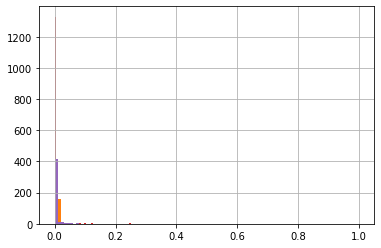

In [108]:
for s in list(set(writings_df.subject.values))[:5]:
    print(s)
    plot_emotion_distr_per_user(s,'sad')

In [115]:
# writings_df.groupby('subject').mean()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']]
writings_df.groupby('subject').median()[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']]

,label,negemo,posemo,affect,sad,anx,pronoun
subject,,,,,,,
subject0,0,0.000000,0.045455,0.067568,0.0,0.0,0.200000
subject1027,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
subject1055,0,0.013077,0.019434,0.047143,0.0,0.0,0.166667
subject1064,1,0.020798,0.052242,0.092119,0.0,0.0,0.185790
subject1089,0,0.000000,0.000000,0.041667,0.0,0.0,0.166667
...,...,...,...,...,...,...,...
subject9917,1,0.029412,0.020309,0.059115,0.0,0.0,0.200000
subject9918,0,0.000000,0.000000,0.038462,0.0,0.0,0.133333
subject992,0,0.000000,0.000000,0.045455,0.0,0.0,0.111111


In [116]:
writings_df[writings_df['subject']=='subject217']['i'].sort_values()
writings_df[writings_df['subject']=='subject217'][['text', 'title', 'i', 'sad', 'anx']].sort_values(by='anx')

,text,title,i,sad,anx
170137,7 hour halflife : after 7 hours there is 50% o...,NaN,0.000000,0.0,0.00
170307,"from the article: ""Two persons once committed ...",NaN,0.000000,0.0,0.00
170308,I can't wait to see /r/behindthegifs version o...,NaN,0.090909,0.0,0.00
170309,HEY! how can you be a lurker and you have 4000...,NaN,0.000000,0.0,0.00
170310,Red labial you say?,NaN,0.000000,0.0,0.00
...,...,...,...,...,...
170519,NaN,you startled the bitch!,0.000000,0.0,0.25
170536,NaN,Ignorance leads to Fear....,0.000000,0.0,0.25
170163,"Yourself, looking very scared.",NaN,0.000000,0.0,0.25
170085,NaN,Horrible mom?,0.000000,0.0,0.50


In [117]:
writings_df[['label', 'negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']].groupby('label').mean()

,negemo,posemo,affect,sad,anx,pronoun
label,,,,,,
0,0.023493,0.050800,0.074548,0.003242,0.002606,0.121043
1,0.026116,0.056145,0.082611,0.003706,0.003591,0.162980


In [118]:
writings_df.columns

Index(['subject', 'title', 'date', 'text', 'label', 'tokenized_title',
       'title_len', 'tokenized_text', 'text_len', 'all_tokens', 'funct',
       'article', 'affect', 'negemo', 'sad', 'cogmech', 'inhib', 'bio', 'body',
       'achieve', 'health', 'sexual', 'adverb', 'preps', 'space', 'relativ',
       'time', 'work', 'certain', 'assent', 'anger', 'posemo', 'insight',
       'verb', 'past', 'money', 'percept', 'social', 'friend', 'motion',
       'cause', 'leisure', 'incl', 'home', 'present', 'humans', 'anx', 'relig',
       'auxverb', 'negate', 'ingest', 'death', 'quant', 'tentat', 'conj',
       'pronoun', 'ipron', 'swear', 'hear', 'family', 'see', 'discrep',
       'number', 'filler', 'feel', 'excl', 'future', 'nonfl', 'ppron', 'shehe',
       'i', 'we', 'you', 'they'],
      dtype='object')

### Feature evolution

In [119]:
users_history_df = pd.DataFrame()
users_history_df['subject'] = writings_df.subject.unique()

In [120]:
users_history_df.set_index('subject')

""
subject
subject8292
subject6644
subject7982
subject9260
subject9918
...
subject835
subject3117
subject519


In [121]:
categs = ['negemo', 'posemo', 'affect', 'sad', 'anx', 'pronoun']
for subject in users_history_df.subject:
    writings = writings_df[writings_df['subject']==subject]
    writings_sorted = writings.sort_values(by='date')
    for categ in categs:
        users_history_df[categ + '_hist'] = writings_sorted[categ].values

ValueError: Length of values does not match length of index

In [34]:
writings_history = writings_df.groupby('subject').aggregate(lambda x: tuple(x))

# df['grouped'] = df['B'] + df['C']

In [35]:
writings_history['label'] = writings_history['label'].apply(lambda v: v[0])

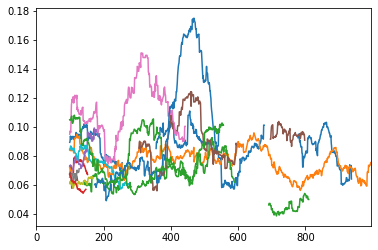

In [39]:
for hist in writings_history[writings_history['label']==1].affect.values:
    if len(hist)<100:
        continue
    pd.Series(hist).rolling(window=100).mean().plot()

## Linear Model

## Hyperparameter tuning

In [133]:
# Declare your hyperparameters search:
tune_epochs=15
config = {
      "algorithm": "random",
      "parameters": {
          "lstm_units": {"type": "integer", "min": 10, "max": 100},
          "dense_bow_units": {"type": "integer", "min": 1, "max": 20},
          "lr": {"type": "float", "min": 0.00001, "max": 0.05, "scalingType": "loguniform"},
          "l2_dense": {"type": "float", "min": 0.00001, "max": 0.5, "scalingType": "loguniform"},
          "dropout": {"type": "float", "min": 0, "max": 0.7, "scalingType": "uniform"},
          "optimizer": {"type": "categorical", "values": ["adam", "adagrad", ""]},
          "batch_size": {"type": "integer", "min": 10, "max": 512, "scalingType": "loguniform"},
          "positive_class_weight": {"type": "integer", "min": 1, "max": 25},
          "trainable_embeddings": {"type": "discrete", "values": [True, False]},
          "freeze_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "lr_reduce_factor": {"type": "float", "min": 0.0001, "max": 0.8},
          "lr_reduce_patience": {"type": "integer", "min": 2, "max": tune_epochs+1},
          "decay": {"type": "float", "min": 0.00000001, "max": 0.5, "scalingType": "loguniform"},          
      },
      "spec": {
          "metric": "loss",
          "objective": "minimize",
      },
  }
optimizer = Optimizer(config, api_key="eoBdVyznAhfg3bK9pZ58ZSXfv")

for experiment in optimizer.get_experiments(project_name="mental"):
    experiment.add_tag("tune")
    
    # Test the model
    hyperparams_config = {
        param: experiment.get_parameter(param) for param in config['parameters'].keys()}
    if not hyperparams_config['optimizer']:
        hyperparams_config['optimizer'] = optimizers.Adam(lr=hyperparams_config['lr'], 
                                   decay=hyperparams_config['decay'])
    model = build_model(hyperparams=hyperparams_config,
                        hyperparams_features=hyperparams_features, 
                        embedding_matrix=embedding_matrix, emotions=emotions,
                       stopwords_list=stopword_list)
    freeze_layer = FreezeLayer(patience=experiment.get_parameter('freeze_patience'),
                              set_to=not experiment.get_parameter('trainable_embeddings'))
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=experiment.get_parameter('lr_reduce_factor'),
                                            patience=experiment.get_parameter('lr_reduce_patience'), 
                                            min_lr=0.000001, verbose=1)
    history = train_model(model, 
            x_train, y_train, x_test, y_test,
            epochs=tune_epochs, batch_size=experiment.get_parameter('batch_size'),
                      class_weight={0:1, 1:experiment.get_parameter('positive_class_weight')}, 
                          workers=2,
                          callback_list = [freeze_layer, reduce_lr],
                      model_path='models/experiment')
    loss = history.history['loss'][-1]
    
    # Report the loss, if not auto-logged:
    experiment.log_metric("loss", loss)

COMET INFO: COMET_OPTIMIZER_ID=786fc2b3654047e69f492db122f55b95
COMET INFO: Using optimizer config: {'algorithm': 'random', 'configSpaceSize': 600000000000, 'endTime': None, 'id': '786fc2b3654047e69f492db122f55b95', 'lastUpdateTime': None, 'maxCombo': 0, 'name': '786fc2b3654047e69f492db122f55b95', 'parameters': {'batch_size': {'max': 512, 'min': 10, 'scalingType': 'loguniform', 'type': 'integer'}, 'decay': {'max': 0.5, 'min': 1e-08, 'scalingType': 'loguniform', 'type': 'float'}, 'dense_bow_units': {'max': 20, 'min': 1, 'scalingType': 'uniform', 'type': 'integer'}, 'dropout': {'max': 0.7, 'min': 0, 'scalingType': 'uniform', 'type': 'float'}, 'freeze_patience': {'max': 16, 'min': 2, 'scalingType': 'uniform', 'type': 'integer'}, 'l2_dense': {'max': 0.5, 'min': 1e-05, 'scalingType': 'loguniform', 'type': 'float'}, 'lr': {'max': 0.05, 'min': 1e-05, 'scalingType': 'loguniform', 'type': 'float'}, 'lr_reduce_factor': {'max': 0.8, 'min': 0.0001, 'scalingType': 'uniform', 'type': 'float'}, 'lr_r

Train...
Train on 111375 samples, validate on 31863 samples
Epoch 1/15
111320/111375 [============================>.] - ETA: 0s - loss: 0.6696 - binary_accuracy: 0.8707 - f1_m: 0.1200 - precision_m: 0.0902 - recall_m: 0.2582
Epoch 00001: val_loss improved from inf to 0.48204, saving model to models/experiment_best
111375/111375 [==============================] - 317s 3ms/sample - loss: 0.6695 - binary_accuracy: 0.8707 - f1_m: 0.1201 - precision_m: 0.0902 - recall_m: 0.2584 - val_loss: 0.4820 - val_binary_accuracy: 0.7968 - val_f1_m: 0.2121 - val_precision_m: 0.1454 - val_recall_m: 0.4314
Epoch 2/15
 47190/111375 [===========>..................] - ETA: 2:52 - loss: 0.5882 - binary_accuracy: 0.8703 - f1_m: 0.1490 - precision_m: 0.1088 - recall_m: 0.2949

KeyboardInterrupt: 